## Section 1: PoRep and CommD/CommR Simulation

In [ ]:
%pip install pycryptodome networkx

In [14]:
import hashlib
import json
import os
import time
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from datetime import datetime, timezone
from Crypto.Cipher import AES
from Crypto.Util import Counter

SECTOR_SIZE = 2048
CHUNK_SIZE = 127
DATA_DIR = "filecoin_sim_full"
REPLICA_DIR = os.path.join(DATA_DIR, "replicas")
ORIGINAL_FILE = os.path.join(DATA_DIR, "original_file.txt")
os.makedirs(REPLICA_DIR, exist_ok=True)

In [15]:
def sha256(data: bytes) -> bytes:
    return hashlib.sha256(data).digest()

def pad_to_sector(data: bytes, size: int = SECTOR_SIZE) -> bytes:
    return data.ljust(size, b'\x00')

def chunk_data(data: bytes, chunk_size: int = CHUNK_SIZE) -> list:
    return [data[i:i + chunk_size] for i in range(0, len(data), chunk_size)]

def merkle_root(chunks: list[bytes]) -> bytes:
    if len(chunks) == 0:
        return b'\x00' * 32
    leaves = [sha256(chunk) for chunk in chunks]
    while len(leaves) > 1:
        if len(leaves) % 2 != 0:
            leaves.append(leaves[-1])
        leaves = [sha256(leaves[i] + leaves[i+1]) for i in range(0, len(leaves), 2)]
    return leaves[0]

In [16]:
def compute_commd(data: bytes) -> (bytes, list):
    padded = pad_to_sector(data)
    pieces = chunk_data(padded)
    commp_hashes = [sha256(piece) for piece in pieces]
    commd = merkle_root(commp_hashes)
    return commd, pieces

def encode_replica(padded_data: bytes, miner_id: str, commd: bytes) -> bytes:
    key = sha256(miner_id.encode() + commd)[:16]
    ctr = Counter.new(128)
    cipher = AES.new(key, AES.MODE_CTR, counter=ctr)
    return cipher.encrypt(padded_data)

def compute_commr(replica_data: bytes) -> bytes:
    replica_chunks = chunk_data(replica_data)
    return merkle_root(replica_chunks)

## Section 2: Pledging and Upgrading

In [17]:
def pledge_sector(miner_id: str, dummy_data: bytes):
    commd, padded_chunks = compute_commd(dummy_data)
    padded_data = b''.join(padded_chunks)
    replica_data = encode_replica(padded_data, miner_id, commd)
    commr = compute_commr(replica_data)
    replica_path = os.path.join(REPLICA_DIR, f"replica_pledge_{miner_id}.bin")
    with open(replica_path, "wb") as f:
        f.write(replica_data)
    return {
        "type": "Pledge",
        "miner_id": miner_id,
        "commd": commd.hex(),
        "commr": commr.hex(),
        "replica_path": replica_path,
        "timestamp": datetime.now(timezone.utc).isoformat()
    }

def upgrade_sector(miner_id: str, real_data: bytes):
    commd, padded_chunks = compute_commd(real_data)
    padded_data = b''.join(padded_chunks)
    replica_data = encode_replica(padded_data, miner_id, commd)
    commr = compute_commr(replica_data)
    replica_path = os.path.join(REPLICA_DIR, f"replica_upgrade_{miner_id}.bin")
    with open(replica_path, "wb") as f:
        f.write(replica_data)
    return {
        "type": "Upgrade",
        "miner_id": miner_id,
        "commd": commd.hex(),
        "commr": commr.hex(),
        "replica_path": replica_path,
        "timestamp": datetime.now(timezone.utc).isoformat()
    }

## Section 3: PoSt Simulation and Failure

In [18]:
def simulate_post(miner_id: str, replica_path: str):
    if not os.path.exists(replica_path):
        return {"type": "PoSt", "miner_id": miner_id, "status": "Failure", "reason": "Replica missing", "timestamp": datetime.now(timezone.utc).isoformat()}
    with open(replica_path, "rb") as f:
        replica = f.read()
    proof = sha256(replica + str(time.time()).encode()).hex()
    return {
        "type": "PoSt",
        "miner_id": miner_id,
        "status": "Success",
        "proof": proof,
        "timestamp": datetime.now(timezone.utc).isoformat(),
        "proof_type": "WinningPoSt2KiB",
        "challenged_sectors": ["<sector_id>"]
    }

In [19]:
with open(ORIGINAL_FILE, "wb") as f:
    f.write(b"This is real data to be used in upgrade. " * 40)

miner_id = "miner_alpha"
dummy_data = b"0" * SECTOR_SIZE
pledge_result = pledge_sector(miner_id, dummy_data)

with open(ORIGINAL_FILE, "rb") as f:
    real_data = f.read()
upgrade_result = upgrade_sector(miner_id, real_data)

post_results = []
for i in range(3):
    post_results.append(simulate_post(miner_id, upgrade_result["replica_path"]))
    time.sleep(1)

os.remove(upgrade_result["replica_path"])
post_results.append(simulate_post(miner_id, upgrade_result["replica_path"]))

print("Pledge Result:")
display(pd.DataFrame([pledge_result]))
print("Upgrade Result:")
display(pd.DataFrame([upgrade_result]))
print("PoSt Results:")
display(pd.DataFrame(post_results))

Pledge Result:


,type,miner_id,commd,commr,replica_path,timestamp
0,Pledge,miner_alpha,af809febd21e7307950f096a017b44419bda7e210bba93...,0cb3b218681ec3f20016ba912b99064d25aa8bddf2005e...,filecoin_sim_full\replicas\replica_pledge_mine...,2025-05-07T13:51:08.377869+00:00


Upgrade Result:


,type,miner_id,commd,commr,replica_path,timestamp
0,Upgrade,miner_alpha,578593bfacb796d12f388ebdbf9e1713afaf173ab8ac7c...,e75c04684f427850cb5530fc0b5c8606d94164217b3b2a...,filecoin_sim_full\replicas\replica_upgrade_min...,2025-05-07T13:51:08.381306+00:00


PoSt Results:


,type,miner_id,status,proof,timestamp,proof_type,challenged_sectors,reason
0,PoSt,miner_alpha,Success,1cac399d5164a500c01efc5edcf067b5aaa8f8779ceb62...,2025-05-07T13:51:08.382391+00:00,WinningPoSt2KiB,[<sector_id>],NaN
1,PoSt,miner_alpha,Success,85a044fa8b09eab10eb7a6249d3590d40b4a05e64277de...,2025-05-07T13:51:09.383197+00:00,WinningPoSt2KiB,[<sector_id>],NaN
2,PoSt,miner_alpha,Success,711fcf7521da7b46c5ed2481044cce8ff9cba41da65436...,2025-05-07T13:51:10.383649+00:00,WinningPoSt2KiB,[<sector_id>],NaN
3,PoSt,miner_alpha,Failure,NaN,2025-05-07T13:51:11.385185+00:00,NaN,NaN,Replica missing


## Section 4: Simulated Filecoin Sealing Pipeline with DRG

In [20]:
def generate_drg_graph(n_nodes=32, expansion_degree=2):
    G = nx.DiGraph()
    for i in range(n_nodes):
        G.add_node(i)
        for j in range(1, expansion_degree + 1):
            if i - j >= 0:
                G.add_edge(i - j, i)
    return G

In [21]:
def precommit1(data: bytes, miner_id: str):
    padded = data.ljust(SECTOR_SIZE, b'\x00')
    graph = generate_drg_graph()
    metadata = {
        "miner_id": miner_id,
        "padded_length": len(padded),
        "graph_nodes": graph.number_of_nodes(),
        "graph_edges": graph.number_of_edges(),
        "timestamp": datetime.now(timezone.utc).isoformat()
    }
    return padded, graph, metadata

In [22]:
def precommit2(padded_data: bytes, miner_id: str):
    commd = sha256(padded_data)
    key = sha256(miner_id.encode() + commd)[:16]
    ctr = Counter.new(128)
    cipher = AES.new(key, AES.MODE_CTR, counter=ctr)
    replica_data = cipher.encrypt(padded_data)
    commr = sha256(replica_data)
    return commd.hex(), commr.hex(), replica_data

In [23]:
def commit1(miner_id: str):
    ticket = sha256(f"{miner_id}-ticket".encode()).hex()
    seed = sha256(f"{miner_id}-seed".encode()).hex()
    challenge = sha256((ticket + seed).encode()).hex()
    proof_blob = f"proof({challenge[:16]})"
    return ticket, seed, challenge, proof_blob

def commit2(proof_blob: str):
    final_proof = sha256(proof_blob.encode()).hex()
    return final_proof

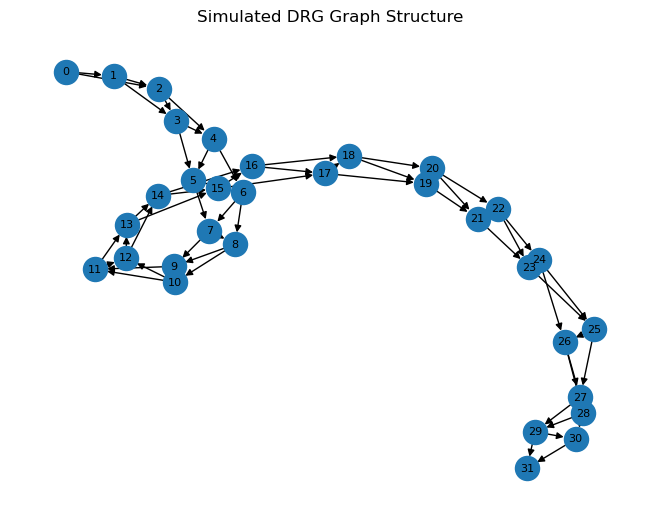

Sealing Metadata:


,miner_id,padded_length,graph_nodes,graph_edges,timestamp
0,miner_beta,2048,32,61,2025-05-07T13:51:11.433527+00:00


Commitments:


,CommD,CommR
0,1b7bc817b5a9da690708cf7adbf914ed43a1169110b386...,4a7617b8029924b107e2788698eb55a51f03bafe7b4914...


Proof Steps:


,Ticket,Seed,Challenge,ProofBlob,FinalProof
0,8b174c784a5037d0e75a67bbde52b46aca0239e5d070de...,c02dfc73bfee9bc9f5b918f880c68e563df182e9330ad9...,f7d588241ecf0c5c0a7297081af54d868e57b1d9641b9e...,proof(f7d588241ecf0c5c),66e620ff7f9ee30bd64a7d7c744aa6520264c098e2766c...


In [24]:
with open(ORIGINAL_FILE, "rb") as f:
    user_data = f.read()

miner_id = "miner_beta"
padded_data, drg_graph, meta = precommit1(user_data, miner_id)
commd, commr, replica_data = precommit2(padded_data, miner_id)
ticket, seed, challenge, proof_blob = commit1(miner_id)
final_proof = commit2(proof_blob)

nx.draw(drg_graph, with_labels=True, node_size=300, font_size=8)
plt.title("Simulated DRG Graph Structure")
plt.show()

print("Sealing Metadata:")
display(pd.DataFrame([meta]))
print("Commitments:")
display(pd.DataFrame([{"CommD": commd, "CommR": commr}]))
print("Proof Steps:")
display(pd.DataFrame([{
    "Ticket": ticket,
    "Seed": seed,
    "Challenge": challenge,
    "ProofBlob": proof_blob,
    "FinalProof": final_proof
}]))